# Tradução Automática e o Conjunto de Dados

Este notebook implementa um estudo de caso de Tradução Automática e o Conjunto de Dados, utilizando o conjunto de dados do Projeto Tatoeba, que contém sentenças paralelas em inglês e japonês. O objetivo deste estudo é construir um pipeline para pré-processamento de texto, tokenização, obtenção de vocabulário e treinamento de um modelo de tradução automática.

## Download e pré-processamento do conjunto de dados do Projeto Tatoeba
Primeiramente, foi feito download e extração do conjunto de dados do projeto Tatoeba. Esse projeto consiste na compilação de traduções diretas de inúmeras frases de um idioma para outro.

In [1]:
!curl "https://www.manythings.org/anki/jpn-eng.zip" -o "jpn-eng.zip"
!unzip *.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4443k  100 4443k    0     0  1924k      0  0:00:02  0:00:02 --:--:-- 1924k
Archive:  jpn-eng.zip
  inflating: jpn.txt                 
  inflating: _about.txt              


In [2]:
!head "_about.txt"

** Info **

Check for newest version here:
  http://www.manythings.org/anki/
Date of this file:
  2024-06-23

This data is from the sentences_detailed.csv file from tatoeba.org.
http://tatoeba.org/files/downloads/sentences_detailed.csv



## Pré-processamento

A função`preproc` foi definida para limpar as sentenças, removendo espaços extras, convertendo para minúsculas e adicionando espaços em torno de pontuações específicas (como 。 ou 、). Este passo é importante porque facilita a tokenização, que é a divisão do texto em palavras significativas.

A função `tokenize` usa a expressão regular \S+ para dividir as sentenças em tokens (palavras) que são não-espaços. Essa abordagem é comum em idiomas como o inglês, onde os espaços são delimitadores naturais de palavras. Para o japonês, a tokenização pode ser mais desafiadora, como discutido na segunda pergunta, que será respondida posteriomente no notebook.

In [3]:
import pandas as pd
import re
from string import punctuation

In [4]:
data = list(map(
    lambda i: i.split("\t")[:2],
    open("jpn.txt", "r").readlines()
))
df = pd.DataFrame(
    data=data,
    columns=["English", "Japanese"],
)

In [5]:
def preproc(s):
    """
    Preprocess the input sentence by performing the following:
    - Strips whitespace from the beginning and end of the string.
    - Converts the string to lowercase.
    - Replaces multiple spaces with a single space.
    - Adds spaces around punctuation marks (from the Japanese punctuation set).

    Args:
    - s (str): The input sentence to be preprocessed.

    Returns:
    - str: The preprocessed sentence.
    """
    PUNCTUATION = punctuation + "。！？、「」、"
    s = s.strip().lower()
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(f'([{re.escape(PUNCTUATION)}])', r' \1 ', s)
    s = s.strip()

    return s

tokenize = lambda s: re.findall(r'\S+', s)
tokenize.__doc__ = """
Tokenizes a sentence into a list of non-space tokens.

Args:
- s (str): The input sentence to tokenize.

Returns:
- list: A list of words/tokens.
"""

In [6]:
from matplotlib import pyplot as plt

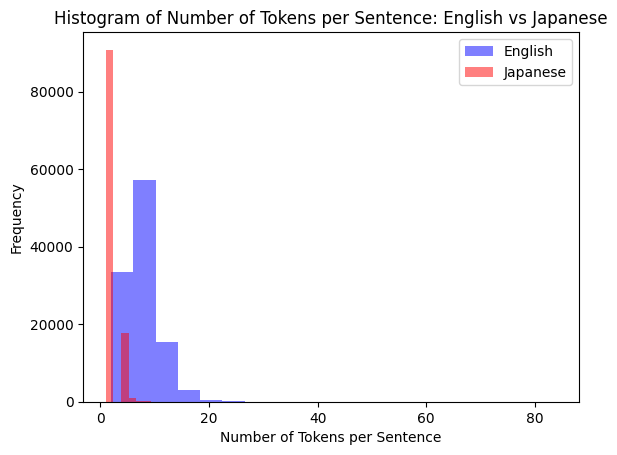

In [7]:
english_lengths = [len(tokenize(preproc(text))) for text in df['English']]
japanese_lengths = [len(tokenize(preproc(text))) for text in df['Japanese']]

plt.hist(english_lengths, bins=20, alpha=0.5, label='English', color='b')
plt.hist(japanese_lengths, bins=20, alpha=0.5, label='Japanese', color='r')

plt.xlabel('Number of Tokens per Sentence')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Tokens per Sentence: English vs Japanese')

plt.legend()

plt.show()
del english_lengths, japanese_lengths

## Obtenção do dataset para treinamento

Nessa seção foram definidas algumas funções importantes para produzir um dataset tensorflow, que pode ser utilizado para a criãção de modelos de AI para tradução direta. Abaixo está a descrição das funções definidas:

- A função `get_vocab` gera uma lista de palavras únicas, ordenadas, a partir das sentenças em inglês e japonês.
- A função `get_indices` converte as palavras das sentenças em índices, associando cada palavra a um número específico, com a introdução de tokens especiais (`<PAD>` e `<UNK>`).
- A função `pad_trunc` usa a função pad_sequences do Keras para garantir que todas as sentenças tenham o mesmo tamanho (definido por `MAX_LEN`), adicionando preenchimento (PAD) ou cortando as sentenças muito longas.
- A função `load_data_nmt` organiza os dados em lotes (batch) para treinamento de modelos de tradução automática, e retorna o dataset pré-processado, pronto para ser usado com TensorFlow.

In [8]:
import tensorflow as tf
import numpy as np

In [12]:
MAX_LEN = 50


get_vocab = lambda df: sorted(
    set(
        [
            word
            for sentence in [tokenize(preproc(sentence)) for sentence in df]
            for word in sentence
        ]
    )
)
get_vocab.__doc__ = """
Generates a sorted vocabulary of unique words from the provided dataset.

Args:
- df (list): A list of sentences in the dataset.

Returns:
- list: A sorted list of unique words in the dataset.
"""

def get_indexed_vocab(vocab):
    """
    Assigns each word in the vocabulary a unique index, starting from 2.
    Special tokens <PAD> and <UNK> are assigned indices 0 and 1, respectively.

    Args:
    - vocab (list): A list of unique words in the vocabulary.

    Returns:
    - dict: A dictionary mapping words to their corresponding indices.
    """
    indexed = {"<PAD>": 0, "<UNK>": 1}
    indexed.update({word: idx + 2 for idx, word in enumerate(vocab)})
    return indexed


def get_indices(indexed_vocab, sentences):
    """
    Converts a list of sentences into their corresponding index representation
    based on the provided indexed vocabulary. Words not found in the vocabulary
    are replaced by the <UNK> token.

    Args:
    - indexed_vocab (dict): A dictionary mapping words to their corresponding indices.
    - sentences (list): A list of sentences to convert.

    Returns:
    - list: A list of sentences, where each sentence is a list of word indices.
    """
    return [
        [
            indexed_vocab.get(word, indexed_vocab["<UNK>"])
            for word in tokenize(preproc(sentence))
        ]
        for sentence in sentences
    ]


pad_trunc = (
    lambda indexed_vocab, indices: tf.keras.preprocessing.sequence.pad_sequences(
        indices, maxlen=MAX_LEN, padding="post", value=indexed_vocab["<PAD>"]
    )
)
pad_trunc.__doc__ = """
Pads or truncates each sentence in the indices list to a fixed length (MAX_LEN).

Args:
- indexed_vocab (dict): A dictionary mapping words to their corresponding indices.
- indices (list): A list of sentences, where each sentence is a list of word indices.

Returns:
- list: A list of padded/truncated sentences.
"""


def load_data_nmt(
    english_dataset, japanese_dataset, max_len=MAX_LEN, batch_size=2, num_steps=8
):
    """
    Loads and processes the English and Japanese datasets for Neural Machine Translation (NMT).
    This includes indexing the vocabularies, padding the sentences, and batching the data.

    Args:
    - english_dataset (list): A list of English sentences.
    - japanese_dataset (list): A list of Japanese sentences.
    - max_len (int, optional): The maximum length of the sentences after padding/truncation. Default is 50.
    - batch_size (int, optional): The size of each batch of data. Default is 2.
    - num_steps (int, optional): The number of steps (batches) to return from the dataset. Default is 8.

    Returns:
    - tf.data.Dataset: A TensorFlow dataset containing the padded English and Japanese sentences
                        along with their corresponding valid lengths.
    """
    indexed_vocab = {
        "English": get_indexed_vocab(get_vocab(english_dataset)),
        "Japanese": get_indexed_vocab(get_vocab(japanese_dataset)),
    }

    indices = {
        "English": get_indices(indexed_vocab["English"], english_dataset),
        "Japanese": get_indices(indexed_vocab["Japanese"], japanese_dataset),
    }

    padded = {
        "English": pad_trunc(indexed_vocab["English"], indices["English"]),
        "Japanese": pad_trunc(indexed_vocab["Japanese"], indices["Japanese"]),
    }

    valid_len = {
        "English": np.array(
            [min(len(sentence), max_len) for sentence in indices["English"]]
        ),
        "Japanese": np.array(
            [min(len(sentence), max_len) for sentence in indices["Japanese"]]
        ),
    }

    dataset = tf.data.Dataset.from_tensor_slices(
        (
            padded["English"],
            valid_len["English"],
            padded["Japanese"],
            valid_len["Japanese"],
        )
    )
    dataset = dataset.shuffle(1000).batch(batch_size).take(num_steps)

    return dataset, indices


In [13]:
train_iter, _ = load_data_nmt(
    df["English"].values, df["Japanese"].values, batch_size=2, num_steps=8
)

for X, X_valid_len, Y, Y_valid_len in train_iter:
    print("X:", tf.cast(X, tf.int32))
    print("valid lengths for X:", X_valid_len)
    print("Y:", tf.cast(Y, tf.int32))
    print("valid lengths for Y:", Y_valid_len)
    break

X: tf.Tensor(
[[ 4145 10638    11     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [ 4678 10638    11     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]], shape=(2, 50), dtype=int32)
valid lengths for X: tf.Tensor([3 3], shape=(2,), dtype=int64)
Y: tf.Tensor(
[[37952   391     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0    

# Respondendo perguntas

> Tente valores diferentes do argumento num_examples na funçãoload_data_nmt. Como isso afeta os tamanhos do vocabulário do idioma de origem e do idioma de destino?

RES: Se você passar um número menor de exemplos (por exemplo `num_examples = 200`), o vocabulário será menor, pois menos palavras únicas estarão presentes. O efeito contrário acontece se são passados mais exemplos.

> O texto em alguns idiomas, como chinês e japonês, não tem indicadores de limite de palavras (por exemplo, espaço). A tokenização em nível de palavra ainda é uma boa ideia para esses casos? Por que ou por que não?

RES: Nesses idiomas, as palavras não são separadas por espaços. Isso dificulta a tokenização em nível de palavra. O processo precisa segmentar os caracteres em palavras significativas. Para isso, seria necessário usar algum outro tipo de biblioteca. Entretanto, como visto no notebook, separar usando espaços com línguas como o japonês ainda é possivel, ainda que o resultado da tokenização seja menos preciso.


In [21]:
examples = 200
print(f"{examples} exemplos")

print(f"Len vocabulário: {len(get_vocab(df['English'][:examples].values)), len(get_vocab(df['Japanese'][:examples].values))}\n")

examples = 1000
print(f"{examples} exemplos")

print(f"Len vocabulário: {len(get_vocab(df['English'][:examples].values)), len(get_vocab(df['Japanese'][:examples].values))}")

200 exemplos
Len vocabulário: (79, 177)

1000 exemplos
Len vocabulário: (386, 809)


In [23]:
english_dataset = df['English'].values
japanese_dataset = df['Japanese'].values

indexed_vocab = {
    "English": get_indexed_vocab(get_vocab(english_dataset)),
    "Japanese": get_indexed_vocab(get_vocab(japanese_dataset)),
}

indices = {
    "English": get_indices(indexed_vocab["English"], english_dataset),
    "Japanese": get_indices(indexed_vocab["Japanese"], japanese_dataset),
}

padded = {
    "English": pad_trunc(indexed_vocab["English"], indices["English"]),
    "Japanese": pad_trunc(indexed_vocab["Japanese"], indices["Japanese"]),
}

print("English: ", padded["English"][0], padded["English"][0].shape)
print("Japanese: ", padded["Japanese"][0], padded["Japanese"][0].shape)

English:  [4628   11    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] (50,)
Japanese:  [90301   391     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0] (50,)
